In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Gaussian Process Regression on a Mesh with **GPflow**

This notebooks shows how to fit a [GPflow](https://www.gpflow.org/) Gaussian process (GP) on a mesh.

In [1]:
# Import a backend, we use gpflow in this example.
import tensorflow as tf
import gpflow

# Import the geometric_kernels backend.
import geometric_kernels
import geometric_kernels.tensorflow

# Import the Mesh space and the general-purpose MaternGeometricKernel
from geometric_kernels.spaces.mesh import Mesh
from geometric_kernels.kernels import MaternGeometricKernel

# The GPflow frontend of GeometricKernels
from geometric_kernels.frontends.gpflow import DefaultFloatZeroMeanFunction, GPflowGeometricKernel

# Sampling routines we will use to create a dummy dataset
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# Stuff
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

# If you remove these, there will be lots of beartype-related warnings during optimization
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel("ERROR")

INFO (geometric_kernels): Numpy backend is enabled, as always. To enable other backends, don't forget `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): Tensorflow backend enabled.


## Mesh Plotting Utils for `plotly`

In [2]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        intensity=vertices_colors,
        **kwargs
    )
    return plot

## Defining a Space

First, we create a GeometricKernels space that corresponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd().parent / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


Now we actually visualize the mesh.

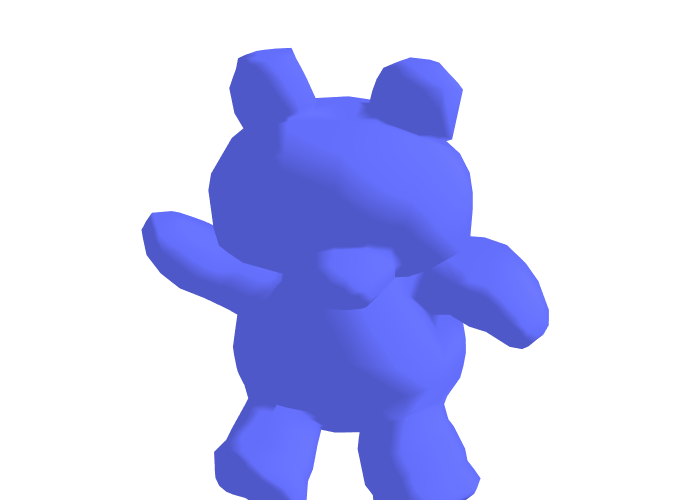

In [4]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show("png")

## Create a Dummy Dataset on the Mesh

We sample from the prior of a GP to create a simple dataset we can afterwards fit using an exact Gaussian process regression (GPR) model.

The input set $X \in \mathbb{N}^{n \times 1}$ consists of **indices** enumerating vertices of the mesh. Consequently, the elements of $X$ are in $[0, N_v-1]$, where $N_v$ are the number of vertices in the mesh.
We sample `num_data` of them into the tensor called `xs_train`. For test inputs `xs_test`, we use the whole $X$.

In [5]:
num_data = 50
key = tf.random.Generator.from_seed(1234)

xs_train = key.uniform(shape=(num_data, 1), minval=0, maxval=mesh.num_vertices, dtype=tf.int64)
xs_test = tf.range(mesh.num_vertices, dtype=tf.int64)[:, None]
# print("xs_train:", xs_train)
# print("xs_test:", xs_test)

To generate the corresponding outputs `ys_train` and `ys_test`, we sample from the prior. To do this, we create a `MaternGeometricKernel` object and use the efficent sampling functionality of GeometricKernels.

In [6]:
base_kernel = MaternGeometricKernel(mesh)

params = base_kernel.init_params()
params["lengthscale"] = tf.convert_to_tensor([5.0], dtype=tf.float64)
params["nu"]  = tf.convert_to_tensor([2.5], dtype=tf.float64)

feature_map = default_feature_map(kernel=base_kernel)
sample_paths = make_deterministic(sampler(feature_map), key)

_, ys_train  = sample_paths(xs_train, params)
key, ys_test = sample_paths(xs_test,  params)

assert(tf.math.reduce_all(tf.equal(tf.gather(ys_test, xs_train[:, 0]), ys_train)))

# print("ys_train:", ys_train)
# print(tf.gather(ys_test, xs_train[:, 0]))

## Build a GPflow Model

Now we wrap the `base_kernel` created above into the `GPflowGeometricKernel` to make an actual GPflow kernel.


**Note:** `params` are external to the `base_kernel` object, thus we need to pass them to the `GPflowGeometricKernel` explicitly.
Otherwise it will use `params = base_kernel.init_params()`. The `trainable_nu` parameter changes whether to treat the smoothness parameter `"nu"` as trainable or fixed. `trainable_nu = True` only works for finite values of `"nu"`, it is incompatible with ``nu = inf``.

In [7]:
kernel = GPflowGeometricKernel(base_kernel, nu = params["nu"],
                               lengthscales=params["lengthscale"],
                               variance=1.0,
                               trainable_nu=False)

We use the data `xs_train`, `ys_train` and the GPflow kernel `kernel` to construct a GPflow model.

**Note:** We use `DefaultFloatZeroMeanFunction` mean: the `ZeroMeanFunction` that GPflow uses by default sets the output dtype equal to the input's dtype, while `DefaultFloatZeroMeanFunction` sets it to `default_float` instead.

In [8]:
model = gpflow.models.GPR(
    (xs_train, ys_train), kernel, mean_function=DefaultFloatZeroMeanFunction(), noise_variance=1e-4
)

from gpflow.utilities import print_summary
print("Initial model:")
print("kernel.nu = ", kernel.nu)
print_summary(model)
print("Initial negative log marginal likelihood:", -model.log_marginal_likelihood().numpy())

Initial model:
kernel.nu =  tf.Tensor([2.5], shape=(1,), dtype=float64)
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [5.]                   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0                    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.likelihood.variance │ Para

## Train the Model (Optimize Hyperparameters)

In [9]:
opt = gpflow.optimizers.Scipy()

print("Starting training...")
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
print("Final model:")
print_summary(model)
print("Final negative log marginal likelihood:", -model.log_marginal_likelihood().numpy())

Starting training...
Final model:
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [5.72748]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.922966133049915     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True    

## Draw Predictions and Evaluate the Model

Recall that `xs_test` contains all the locations on the mesh, i.e. all numbers from the set $\{0, 1, \ldots, N_v-1\}$.

In [10]:
# predict mean and variance
posterior_mean, posterior_variance = model.predict_f(xs_test)
posterior_mean = posterior_mean.numpy()
posterior_std = np.sqrt(posterior_variance.numpy())

# predict sample
sample = model.predict_f_samples(xs_test).numpy()

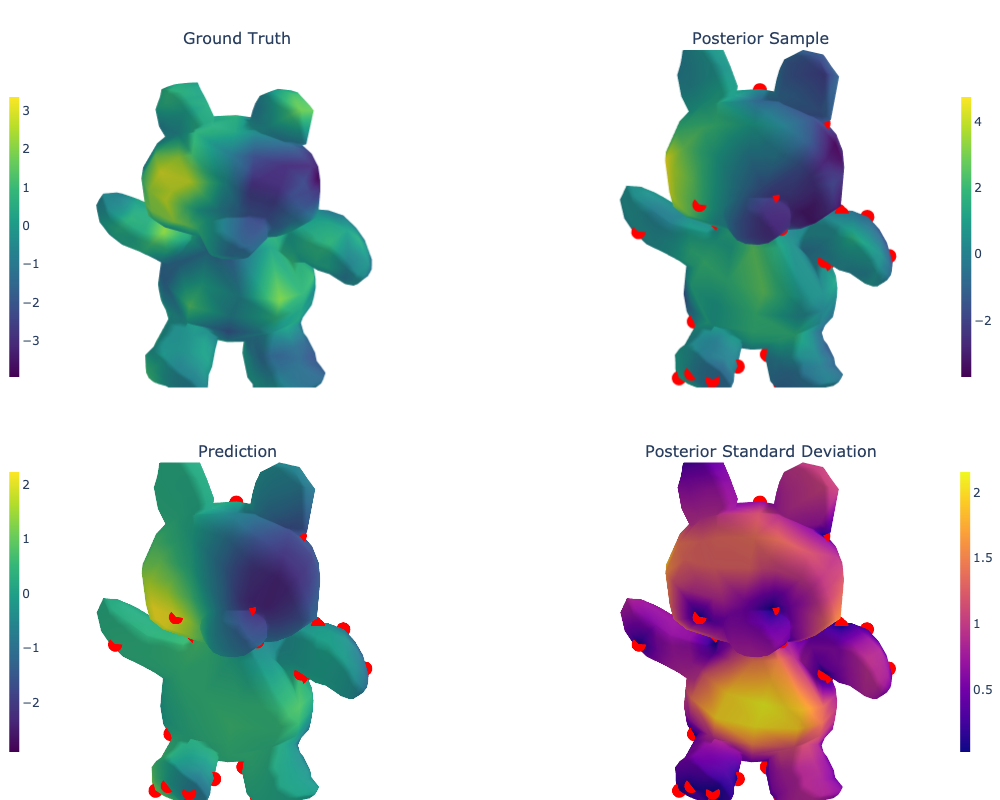

In [11]:
# Mark training data
training_data_coords = tf.gather(mesh.vertices, xs_train[:, 0])

training_data_plot  = go.Scatter3d(
    x=np.array(training_data_coords[:, 0]),
    y=np.array(training_data_coords[:, 1]),
    z=np.array(training_data_coords[:, 2]),
    mode = "markers",
    marker_color = "red",
    name="",
    showlegend=False,
)

# Various plots as plotly traces
ground_truth_plot   = plot_mesh(mesh, vertices_colors=ys_test, colorscale="Viridis",
                                colorbar=dict(
                                x=0, 
                                y=0.75, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )
sample_plot         = plot_mesh(mesh, vertices_colors=sample, colorscale="Viridis",
                                colorbar=dict(
                                x=1.0, 
                                y=0.75,
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

posterior_mean_plot = plot_mesh(mesh, vertices_colors=posterior_mean, colorscale="Viridis",
                                colorbar=dict(
                                x=0.0, 
                                y=0.25, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4,
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

posterior_std_plot  = plot_mesh(mesh, vertices_colors=posterior_std, colorscale="Plasma",
                                colorbar=dict(
                                x=1.0, 
                                y=0.25, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "surface"}, {"type": "surface"}],
           [{"type": "surface"}, {"type": "surface"}]],
    subplot_titles=(r"Ground Truth",
                    r"Posterior Sample",
                    r"Prediction",
                    r"Posterior Standard Deviation"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(ground_truth_plot,   row=1, col=1)

fig.add_trace(training_data_plot,  row=1, col=2)
fig.add_trace(sample_plot,         row=1, col=2)

fig.add_trace(training_data_plot,  row=2, col=1)
fig.add_trace(posterior_mean_plot,  row=2, col=1)

fig.add_trace(training_data_plot,  row=2, col=2)
fig.add_trace(posterior_std_plot, row=2, col=2)


fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={"t": 50},
)

fig.show("png", width=1000, height=800)